# Coupon Redemption Prediction

Problem Statement

Predicting Coupon Redemption

XYZ Credit Card company regularly helps it’s merchants understand their data better and take key business decisions accurately by providing machine learning and analytics consulting. ABC is an established Brick & Mortar retailer that frequently conducts marketing campaigns for its diverse product range. As a merchant of XYZ, they have sought XYZ to assist them in their discount marketing process using the power of machine learning. Can you wear the AmExpert hat and help out ABC?
 
Discount marketing and coupon usage are very widely used promotional techniques to attract new customers and to retain & reinforce loyalty of existing customers. The measurement of a consumer’s propensity towards coupon usage and the prediction of the redemption behaviour are crucial parameters in assessing the effectiveness of a marketing campaign.
 
ABC’s promotions are shared across various channels including email, notifications, etc. A number of these campaigns include coupon discounts that are offered for a specific product/range of products. The retailer would like the ability to predict whether customers redeem the coupons received across channels, which will enable the retailer’s marketing team to accurately design coupon construct, and develop more precise and targeted marketing strategies.
 
The data available in this problem contains the following information, including the details of a sample of campaigns and coupons used in previous campaigns -
•	User Demographic Details
•	Campaign and coupon Details
•	Product details
•	Previous transactions
Based on previous transaction & performance data from the last 18 campaigns, predict the probability for the next 10 campaigns in the test set for each coupon and customer combination, whether the customer will redeem the coupon or not?
 
 

To summarise the entire process:
•	Customers receive coupons under various campaigns and may choose to redeem it.
•	They can redeem the given coupon for any valid product for that coupon as per coupon item mapping within the duration between campaign start date and end date
•	Next, the customer will redeem the coupon for an item at the retailer store and that will reflect in the transaction table in the column coupon_discount.



In [208]:
import pandas as pd
import gc
import pickle
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV 
import xgboost as xgb
from sklearn import metrics

In [209]:
# Force pandas to use 32bit representations of integers and floats instead of 64bit. Hopefully, this will help to reduce
# memory consumption
train_dtypes = {
    'id': 'int32',
    'resumption_status': 'uint8',
    'campaign_id': 'int32',
    'customer_id': 'int32',
    'coupon_id': 'int32',
}
test_dtypes = {
    'id': 'int32',
    'campaign_id': 'int32',
    'customer_id': 'int32',
    'coupon_id': 'int32',
}
transaction_dtypes = {
    'customer_id': 'int32',
    'item_id': 'int32',
    'quantity': 'float32',
    'selling_price': 'float32',
    'other_discount': 'float32',
    'coupon_discount': 'float32',
}
customer_dtypes = {
    'customer_id': 'int32',
    'rented': 'float32',
    'income_bracket': 'float32',
}
campaign_dtypes = {
    'customer_id': 'int32',
    'campaign_id': 'int32',
}
item_dtypes = {
    'coupon_id': 'int32',
    'item_id': 'int32',
}
coupon_item_dtypes = {
    'coupon_id': 'int32',
    'item_id': 'int32',
}

In [210]:
# Read the train and test csv files
train_df = pd.read_csv('train.csv', dtype=train_dtypes)
test_df = pd.read_csv('test_QyjYwdj.csv', dtype=test_dtypes)

# Concatenate the train and test data frames because other dataframes (transaction, items, etc.) contain data
# of both train and test
concatenated_df =  pd.concat((train_df.drop(columns=['redemption_status']), test_df))

# Read the remaining csv files
transaction_df = pd.read_csv('customer_transaction_data.csv', dtype=transaction_dtypes)
item_df = pd.read_csv('item_data.csv', dtype=item_dtypes)
customer_df = pd.read_csv('customer_demographics.csv', dtype=customer_dtypes)
coupon_item_df = pd.read_csv('coupon_item_mapping.csv', dtype=coupon_item_dtypes)
campaign_df = pd.read_csv('campaign_data.csv', dtype=campaign_dtypes)


customer_df['age_range']=customer_df['age_range'].str.rstrip('+')
customer_df['age_range']=customer_df['age_range'].str.split('-')
#customer_df['age_range']=customer_df['age_range'].str.rstrip('+')

def conversion(tmp):

    coldif=[]
    for i in range(0,len(tmp)):
        if len(tmp[i])==1:
            coldif.append(int(tmp[i][0]))

        else:
            for j in range(0,len(tmp[i])):
                coldif.append((int(tmp[i][j+1])+int(tmp[i][j]))/2)
                break
    tmp=coldif
    return tmp

customer_df['age_range']=conversion(customer_df['age_range'])

#Replacing null values for children with -1
customer_df['no_of_children']=np.where((customer_df['no_of_children'].isnull()),'-1',customer_df['no_of_children'])

customer_df['no_of_children']=customer_df['no_of_children'].str.rstrip('+')
customer_df['no_of_children']=customer_df['no_of_children'].astype(int)

customer_df['marital_status']=np.where(((customer_df['marital_status'].isnull())\
                                       & ((customer_df['no_of_children'])>=1)),'Married',customer_df['marital_status'])

customer_df['family_size']=customer_df['family_size'].str.rstrip('+')
customer_df['family_size']=customer_df['family_size'].astype(int)

customer_df['marital_status']=np.where((customer_df['marital_status'].isnull())\
                                       & (customer_df['family_size']==1),'Single',customer_df['marital_status'])

customer_df['marital_status']=np.where((customer_df['marital_status'].isnull())\
                                       & (customer_df['family_size']==2) & (customer_df['age_range']>45)\
                                       ,'Married',customer_df['marital_status'])

customer_df['marital_status']=np.where((customer_df['marital_status'].isnull())\
                                       & (customer_df['family_size']==2) & (customer_df['age_range']<42)\
                                       ,'Single',customer_df['marital_status'])

customer_df['no_of_children']=np.where((customer_df['no_of_children']==-1)\
                                       & ((customer_df['marital_status'])=='Single') \
                                       & (customer_df['family_size']>=3),2,customer_df['no_of_children'])
customer_df['no_of_children']=np.where((customer_df['no_of_children']==-1)\
                                       & (customer_df['family_size']<=2) \
                                       & (customer_df['age_range']>=40),0,customer_df['no_of_children'])
customer_df['no_of_children']=np.where((customer_df['no_of_children']==-1)\
                                       & (customer_df['marital_status']=='Single') \
                                       & (customer_df['age_range']<=42),1,customer_df['no_of_children'])
customer_df['no_of_children']=np.where((customer_df['no_of_children']==-1)\
                                       & (customer_df['marital_status']=='Married') \
                                       & (customer_df['age_range']<=40),1,customer_df['no_of_children'])
marriage_bin={'Married':2,
             'Single':1}

customer_df['marital_status']=customer_df['marital_status'].map(marriage_bin)

customer_campaign_df=concatenated_df.merge(customer_df,how='left',left_on=['customer_id'],right_on=['customer_id'])\
                    .merge(campaign_df,how='left',left_on=['campaign_id'],right_on=['campaign_id'])

transaction_item_coupon_df=coupon_item_df.merge(item_df,how='left',left_on=['item_id'],right_on=['item_id'])\
                            .merge(transaction_df,how='right',left_on=['item_id'],right_on=['item_id'])

merged_df = customer_campaign_df.merge(transaction_item_coupon_df, how="left", 
           left_on=["coupon_id", "customer_id"], right_on=["coupon_id", "customer_id"])

train=pd.DataFrame({'id':train_df.id,'resumption_status': train_df.redemption_status})\
                    .merge(merged_df,how='inner',left_on=["id"], right_on=["id"])
test = pd.DataFrame(test_df.id)\
        .merge(merged_df, how="inner", left_on=["id"], right_on=["id"])

train['age_range'].value_counts()
train['age_range']=np.where(train['age_range'].isnull(),40.5,train['age_range'])
test['age_range']=np.where(test['age_range'].isnull(),40.5,test['age_range'])

train['marital_status']=np.where(train['marital_status'].isnull(),2,train['marital_status'])
test['marital_status']=np.where(test['marital_status'].isnull(),2,test['marital_status'])

train['rented']=np.where(train['rented'].isnull(),train['rented'].mode(),train['rented'])
test['rented']=np.where(test['rented'].isnull(),test['rented'].mode(),test['rented'])

train['family_size']=np.where(train['family_size'].isnull(),train['family_size'].mode(),train['family_size'])
test['family_size']=np.where(test['family_size'].isnull(),test['family_size'].mode(),test['family_size'])

train['no_of_children']=np.where(train['no_of_children'].isnull(),train['no_of_children'].mode(),train['no_of_children'])
train['income_bracket']=np.where(train['income_bracket'].isnull(),train['income_bracket'].mode(),train['income_bracket'])

test['no_of_children']=np.where(test['no_of_children'].isnull(),test['no_of_children'].mode(),test['no_of_children'])
test['income_bracket']=np.where(test['income_bracket'].isnull(),test['income_bracket'].mode(),test['income_bracket'])

#Removing columns which have all null values
train=train.dropna(axis=1, how='all')
#Removing rows which have all null values
train=train.dropna(axis=0, how='all')

#Removing columns which have all null values
test=test.dropna(axis=1, how='all')
#Removing rows which have all null values
test=test.dropna(axis=0, how='all')

#Deleting rows which have more than 39% null values
#train=train.dropna(thresh=18)

#Deleting rows which have more than 39% null values
#test=test.dropna(thresh=14)

from datetime import datetime

train['date']=pd.to_datetime(train['date'])
train['start_date']=pd.to_datetime(train['start_date'])
train['end_date']=pd.to_datetime(train['end_date'])

test['date']=pd.to_datetime(test['date'])
test['start_date']=pd.to_datetime(test['start_date'])
test['end_date']=pd.to_datetime(test['end_date'])

train['coupon_avaiable']=np.where((train['date'].notnull()) & (train['date']>=train['start_date']) & (train['date']<=train['end_date']),1,0)

test['coupon_avaiable']=np.where((test['date'].notnull()) & (test['date']>=test['start_date']) & (test['date']<=test['end_date']),1,0)

train['coupon_discount']=np.where(train['coupon_discount'].isnull(),0.0,train['coupon_discount'])
train['other_discount']=np.where(train['other_discount'].isnull(),0.0,train['other_discount'])
train['selling_price']=np.where(train['selling_price'].isnull(),0.0,train['selling_price'])
train['quantity']=np.where(train['quantity'].isnull(),0.0,train['quantity'])
train['category']=np.where(train['category'].isnull(),'nill',train['category'])
train['brand_type']=np.where(train['brand_type'].isnull(),'nill',train['brand_type'])
train['brand']=np.where(train['brand'].isnull(),0.0,train['brand'])
train['item_id']=np.where(train['item_id'].isnull(),0.0,train['item_id'])

test['coupon_discount']=np.where(test['coupon_discount'].isnull(),0.0,test['coupon_discount'])
test['other_discount']=np.where(test['other_discount'].isnull(),0.0,test['other_discount'])
test['selling_price']=np.where(test['selling_price'].isnull(),0.0,test['selling_price'])
test['quantity']=np.where(test['quantity'].isnull(),0.0,test['quantity'])
test['category']=np.where(test['category'].isnull(),'nill',test['category'])
test['brand_type']=np.where(test['brand_type'].isnull(),'nill',test['brand_type'])
test['brand']=np.where(test['brand'].isnull(),0.0,test['brand'])
test['item_id']=np.where(test['item_id'].isnull(),0.0,test['item_id'])

train=train.drop_duplicates(['id'],keep='first')
test=test.drop_duplicates(['id'],keep='first')

train=train.drop(['start_date','end_date','date'],axis=1)
test=test.drop(['start_date','end_date','date'],axis=1)

from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()

col_obj=list(train.select_dtypes(include='object').columns)


col_more=[]
col_bin=[]
col_single=[]
for col in col_obj:
    if len(train[col].value_counts().index)>6:
        col_more.append(col)
    elif len((train[col].value_counts().index))<=2 and (len(train[col].value_counts().index))>1:
        col_bin.append(col)
    else:
        col_single.append(col)  

for col in col_more:
    train[col]=lb.fit_transform(train[col])
    test[col]=lb.transform(test[col])

train['category']=np.where(train['category']==12,0,train['category'])
test['category']=np.where(test['category']==12,0,test['category'])

brand_bin={'Established':2,'Local':1,'nill':0}

train['brand_type']=train['brand_type'].map(brand_bin)
test['brand_type']=test['brand_type'].map(brand_bin)

campaign_bin={'X':2,'Y':1}

train['campaign_type']=train['campaign_type'].map(campaign_bin)
test['campaign_type']=test['campaign_type'].map(campaign_bin)

train.to_csv('train4.csv',index=False)
test.to_csv('test4.csv',index=False)

train=pd.read_csv('train3.csv')
test=pd.read_csv('test3.csv')

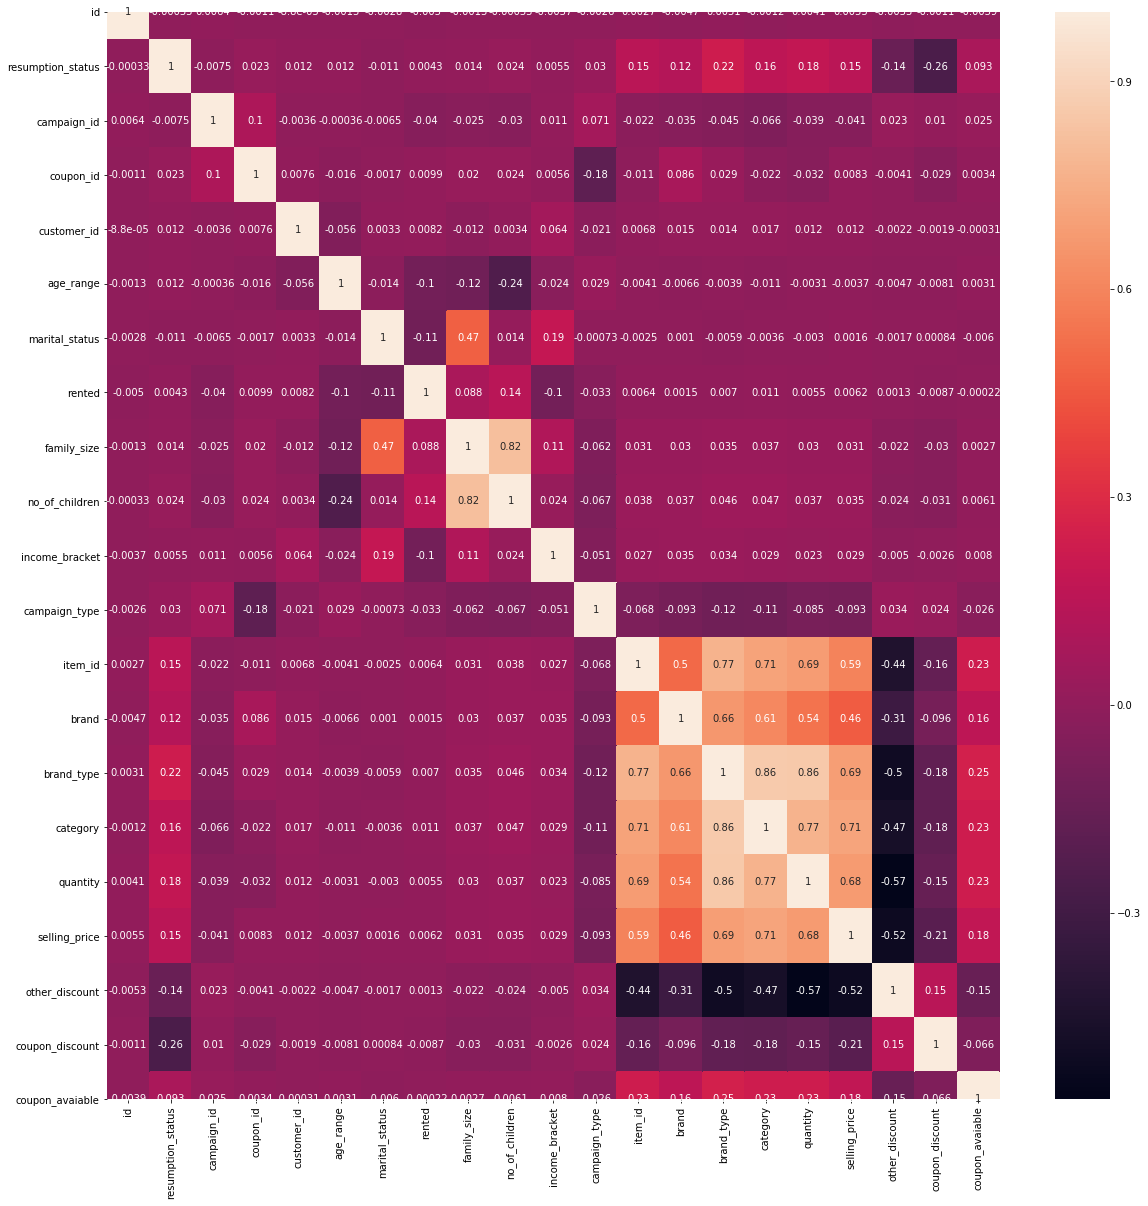

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,20))
sns.heatmap(train.corr(),annot = True)

In [212]:
train=train.drop(['category','brand','family_size','quantity','item_id','selling_price'],axis=1)
test=test.drop(['category','brand','family_size','quantity','item_id','selling_price'],axis=1)

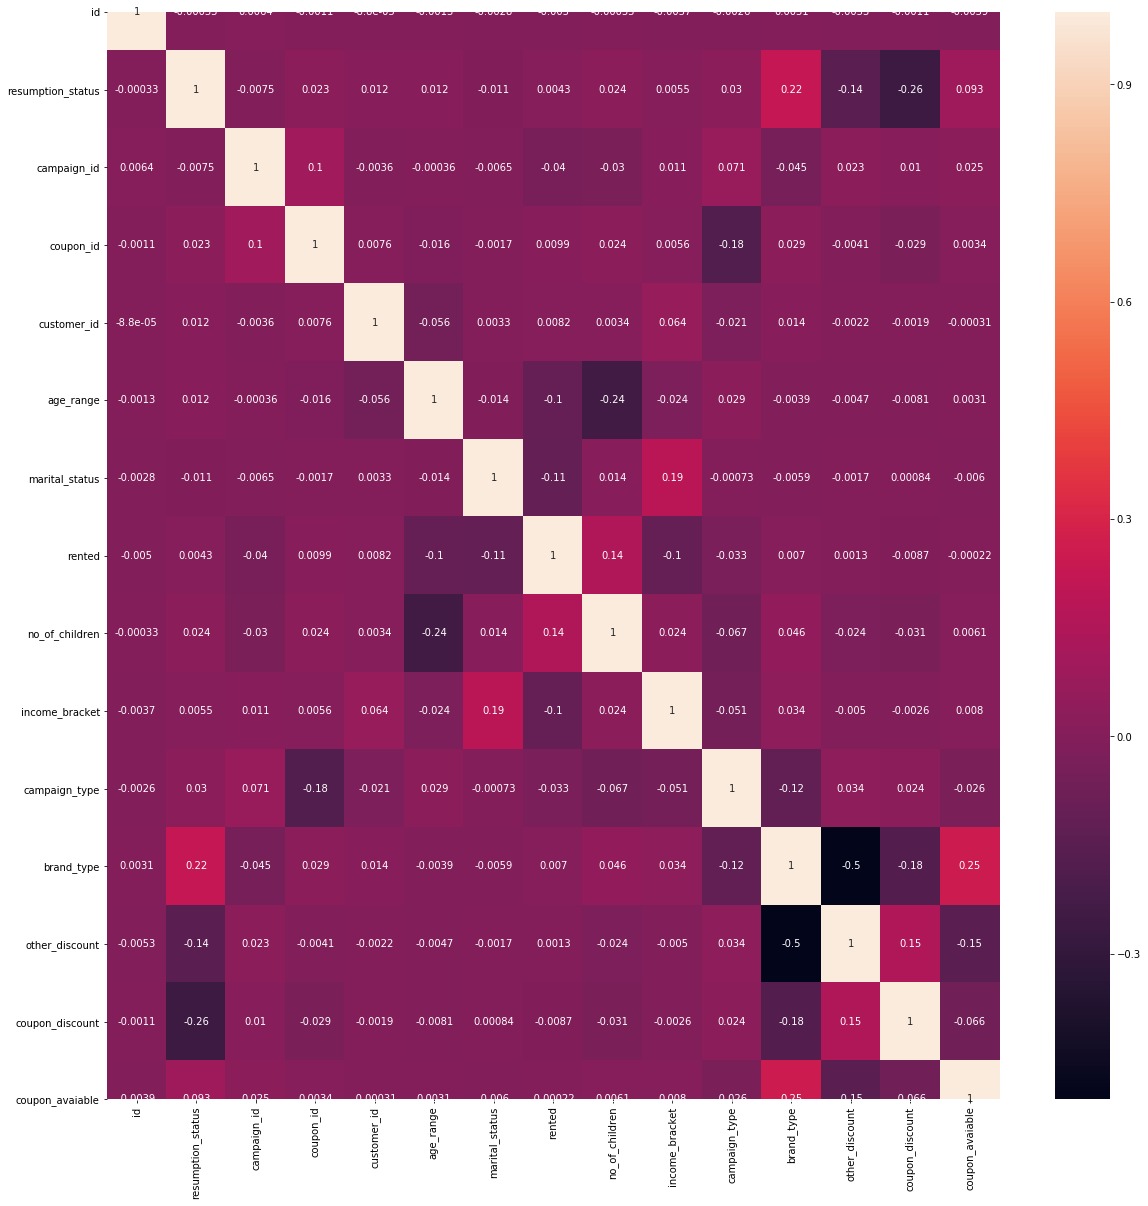

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,20))
sns.heatmap(train.corr(),annot = True)

In [214]:
train=train.set_index('id')
test=test.set_index('id')

y=train['resumption_status']
X=train.drop(['resumption_status'],axis=1)


ratio=(sum(train['resumption_status']==0/sum(train['resumption_status']==1)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [215]:
X_train.shape

(54858, 13)

In [216]:
y_train.shape

(54858,)

In [217]:
col=train.columns

In [218]:
col=[i for i in col if i!='resumption_status']

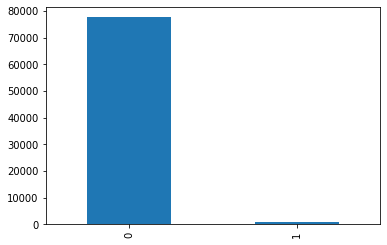

In [219]:
train['resumption_status'].value_counts().plot.bar()

In [220]:

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [221]:
X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())


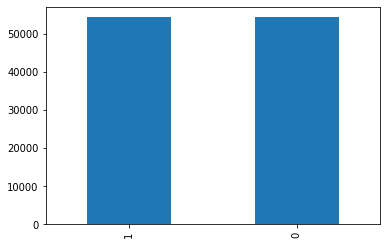

In [222]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [223]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_new = sc.fit_transform(X_train_new)
X_test = sc.transform(X_test)

In [62]:
classifier = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=112,
 max_depth=9,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 objective= 'binary:logistic',
 nthread=4,
 reg_lambda=5,
# max_delta_step=1,
 alpha=0.1,
 scale_pos_weight=ratio ,                             
 scoring='roc_auc',
 seed=1029)

classifier.fit(X_train_new, y_train_new)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=5, missing=None, n_estimators=112, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=5, scale_pos_weight=77640,
              scoring='roc_auc', seed=1029, silent=None, subsample=0.8,
              verbosity=1)

In [63]:
X_test.columns

Index(['campaign_id', 'coupon_id', 'customer_id', 'age_range',
       'marital_status', 'rented', 'no_of_children', 'income_bracket',
       'campaign_type', 'brand_type', 'other_discount', 'coupon_discount',
       'coupon_avaiable'],
      dtype='object')

In [224]:
X_train_new=pd.DataFrame(data=X_train_new,columns=X_train.columns)

In [64]:
# prediction for Training data
train_pred_sm = classifier.predict(X_train_new)

# prediction for Testing data
test_pred_sm = classifier.predict(X_test)

In [65]:
print('Accuracy score for Training Dataset = ', accuracy_score(train_pred_sm, y_train_new))
print('Accuracy score for Testing Dataset = ', accuracy_score(test_pred_sm, y_test))


Accuracy score for Training Dataset =  0.9414276773552258
Accuracy score for Testing Dataset =  0.8829484071285781


In [66]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 2)}

# instantiate the model
rf =xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=ratio, seed=27)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc')
rf.fit(X_train_new, y_train_new)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=77640, seed=27,
                                     silent=None, subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(2, 20, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [67]:
# scores of GridSearch CV
scores = rf.cv_results_
k=pd.DataFrame(scores).head()

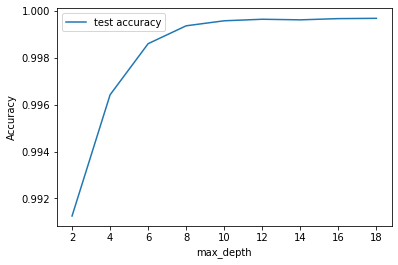

In [68]:
# plotting accuracies with max_depth
plt.figure()

plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [79]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# instantiate the model
rf =xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
 min_child_weight=1, max_depth=18, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc')
rf.fit(X_train_new, y_train_new)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=18, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc

In [80]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,24.644539,1.358734,0.306684,0.037635,0,{'gamma': 0.0},0.999528,0.999997,0.999997,0.999841,0.000221,1
1,26.788532,4.722786,0.311685,0.065499,0.1,{'gamma': 0.1},0.999517,0.999997,0.999996,0.999837,0.000226,4
2,25.107436,2.198127,0.288683,0.033232,0.2,{'gamma': 0.2},0.999523,0.999998,0.999996,0.999839,0.000224,3
3,42.856451,17.952314,0.392022,0.124982,0.3,{'gamma': 0.3},0.999524,0.999998,0.999995,0.999839,0.000223,2
4,53.076036,11.686204,0.369021,0.033538,0.4,{'gamma': 0.4},0.999509,0.999997,0.999996,0.999834,0.000229,5


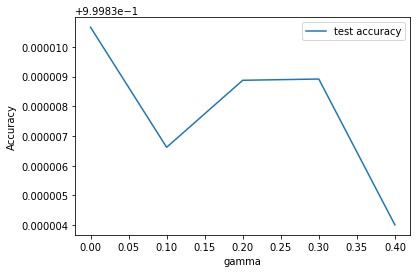

In [82]:
# plotting accuracies with max_depth
plt.figure()

plt.plot(scores["param_gamma"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [83]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {
 'subsample':[i/10.0 for i in range(6,10)]
}

# instantiate the model
rf =xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
 min_child_weight=1, max_depth=18, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc')
rf.fit(X_train_new, y_train_new)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=18, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'subsample': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', 

In [84]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,68.745058,27.584350,0.623036,0.065001,0.6,{'subsample': 0.6},0.999522,0.999996,0.999996,0.999838,0.000223,4
1,79.858901,23.527010,0.352020,0.089340,0.7,{'subsample': 0.7},0.999526,0.999996,0.999996,0.999839,0.000222,3
2,33.763387,2.777191,0.353354,0.042666,0.8,{'subsample': 0.8},0.999528,0.999997,0.999997,0.999841,0.000221,2
3,36.275007,10.615350,0.274349,0.009464,0.9,{'subsample': 0.9},0.999532,0.999997,0.999996,0.999842,0.000219,1


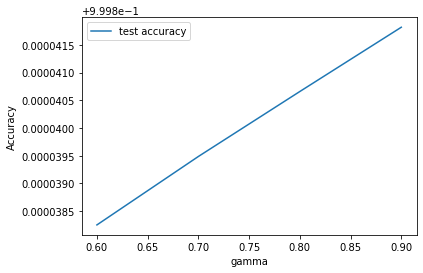

In [85]:
# plotting accuracies with max_depth
plt.figure()

plt.plot(scores["param_subsample"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [86]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {
  'colsample_bytree':[i/10.0 for i in range(6,10)],
}

# instantiate the model
rf =xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
 min_child_weight=1, max_depth=18, subsample=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc')
rf.fit(X_train_new, y_train_new)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=18, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc

In [87]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,23.731422,5.257032,0.297350,0.038441,0.6,{'colsample_bytree': 0.6},0.999528,0.999998,0.999999,0.999842,0.000222,3
1,23.069319,1.778761,0.346020,0.026872,0.7,{'colsample_bytree': 0.7},0.999551,0.999998,0.999996,0.999848,0.000210,1
2,23.519679,2.455364,0.277683,0.044457,0.8,{'colsample_bytree': 0.8},0.999532,0.999997,0.999996,0.999842,0.000219,2
3,25.671802,1.252302,0.294683,0.031543,0.9,{'colsample_bytree': 0.9},0.999519,0.999997,0.999994,0.999837,0.000225,4


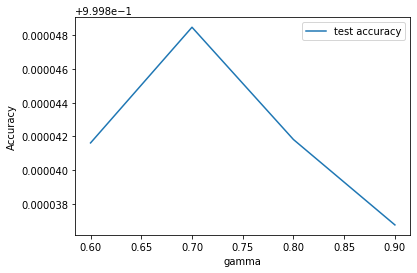

In [88]:
# plotting accuracies with max_depth
plt.figure()

plt.plot(scores["param_colsample_bytree"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [89]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 3

# parameters to build the model on
parameters = {
  'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

# instantiate the model
rf =xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, 
 min_child_weight=1, max_depth=18, subsample=0.9,colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring='roc_auc')
rf.fit(X_train_new, y_train_new)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.7, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=18, min_child_weight=1,
                                     missing=None, n_estimators=140, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=27, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='ro

In [90]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,34.252952,6.948463,0.332686,0.013276,1e-05,{'reg_alpha': 1e-05},0.999551,0.999998,0.999996,0.999848,0.000210,1
1,22.635961,2.360317,0.280349,0.041902,0.01,{'reg_alpha': 0.01},0.999552,0.999998,0.999995,0.999848,0.000210,2
2,23.473676,1.309555,0.304351,0.026286,0.1,{'reg_alpha': 0.1},0.999550,0.999998,0.999996,0.999848,0.000211,3
3,20.844192,1.607976,0.263348,0.029046,1,{'reg_alpha': 1},0.999539,0.999997,0.999996,0.999844,0.000216,4
4,13.955780,0.842574,0.211679,0.031353,100,{'reg_alpha': 100},0.998218,0.999021,0.998860,0.998700,0.000347,5


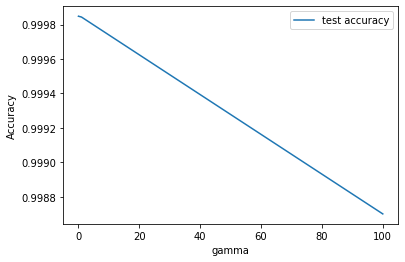

In [91]:
# plotting accuracies with max_depth
plt.figure()

plt.plot(scores["param_reg_alpha"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [225]:
classifier = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=112,
 max_depth=12,
 min_child_weight=5,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.7,
 objective= 'binary:logistic',
 nthread=4,
 reg_lambda=5,
# max_delta_step=1,
 reg_alpha=0.1,
 scale_pos_weight=1 ,                             
 scoring='roc_auc',
 seed=1029)

classifier.fit(X_train_new, y_train_new)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=5, missing=None, n_estimators=112, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0.1, reg_lambda=5, scale_pos_weight=1,
              scoring='roc_auc', seed=1029, silent=None, subsample=0.9,
              verbosity=1)

In [191]:
y_pred = classifier.predict_proba(X_train)
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Let's see the head
y_pred_1.head()
# Converting y_train to dataframe
y_train_df = pd.DataFrame(y_train)
y_train_df['id'] = y_train_df.index
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_train_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['Prospect ID','Converted','Churn_Prob'], axis=1)
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_pred_final.head()

,resumption_status,id,Churn_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,23180,0.000176,1,0,0,0,0,0,0,0,0,0
1,0,108564,0.000125,1,0,0,0,0,0,0,0,0,0
2,0,100504,0.000105,1,0,0,0,0,0,0,0,0,0
3,0,10611,0.000136,1,0,0,0,0,0,0,0,0,0
4,0,80681,0.000178,1,0,0,0,0,0,0,0,0,0


In [192]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.1,0.2,0.3,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = confusion_matrix(y_pred_final.resumption_status, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.1   0.1  0.979164  0.838772  0.980511
0.2   0.2  0.988206  0.733205  0.990651
0.3   0.3  0.990922  0.646833  0.994221
0.4   0.4  0.992180  0.554702  0.996374
0.5   0.5  0.992781  0.491363  0.997589
0.6   0.6  0.992927  0.424184  0.998380
0.7   0.7  0.992964  0.360845  0.999025
0.8   0.8  0.992781  0.285988  0.999558
0.9   0.9  0.992052  0.174664  0.999890


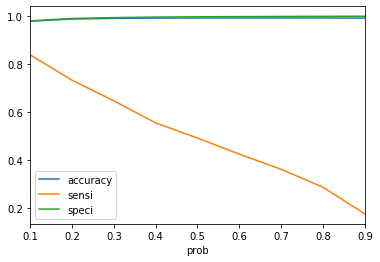

In [193]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
import matplotlib.pyplot as plt
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [194]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.3 else 0)
# Let's check the overall accuracy.
accuracy_score(y_pred_final.resumption_status, y_pred_final.final_predicted)

0.9909220168434868

In [196]:
# Predicted probabilities on test data
y_pred = classifier.predict_proba(X_test)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df['id'] = y_test_df.index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Churn_Prob'})
# Creating new column 'predicted' with 1 if Churn_Prob>0.4 else 0
y_pred_final['predicted'] = y_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.29 else 0)
#Let's check the overall accuracy.
accuracy_score(y_pred_final.resumption_status, y_pred_final.predicted)

0.9905576113308664

In [197]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

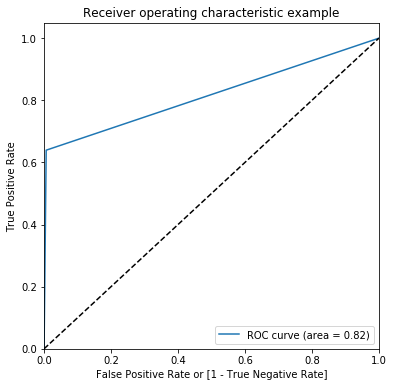

(array([0.       , 0.0063082, 1.       ]),
 array([0.        , 0.63942308, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [198]:
draw_roc(y_pred_final.resumption_status, y_pred_final.predicted)

In [199]:
X_test=test
# Predicted probabilities on test data
y_pred = classifier.predict_proba(X_test)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
#y_test_df['id'] = y_test_df.index
y_pred_1.columns
y_pred_1.columns=['redemption_status']
# Creating new column 'predicted' with 1 if Churn_Prob>0.4 else 0
y_pred_1.redemption_status = y_pred_1.redemption_status.map( lambda x: 1 if x > 0.29 else 0)
y_pred_1=y_pred_1.set_index([test.index])
y_pred_1.to_csv('submission_after_elimination.csv')

c:\users\user\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [206]:
X_test=test
# Predicted probabilities on test data
y_pred = classifier.predict_proba(X_test)
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)
# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]
#y_test_df['id'] = y_test_df.index
y_pred_1.columns
y_pred_1.columns=['redemption_status']
# Creating new column 'predicted' with 1 if Churn_Prob>0.4 else 0
y_pred_1.redemption_status = y_pred_1.redemption_status.map( lambda x: 1 if x > 0.29 else 0)
y_pred_1=y_pred_1.set_index([test.index])
y_pred_1.to_csv('submission_after_elimination.csv')

In [207]:
y_pred_1

,redemption_status
id,
3,1
4,0
5,0
8,0
10,0
12,0
13,0
16,0
18,0
